# Symantic Classification of Urban Settlements
## Mort Canty
## June, 2021

## Context
 
[Fully convolutional neural networks](https://ieeexplore.ieee.org/document/7478072) (FCNs) are useful for object recognition and semantic image classification. In this tutorial we examine a popular FCN architecture, called [UNet](https://arxiv.org/abs/1505.04597), for urban building recognition (houses, commercial edifices, etc.) in aerial or satellite imagery. We make use of the dataset  for the [INRIA Aerial Imaging Labeling Benchmark](https://hal.inria.fr/hal-01468452/document) published in 2016. The dataset, consisting of images and semantic labels, can be downloaded [here](https://project.inria.fr/aerialimagelabeling/), and a presentation of the most successful sematic classifiers determined in the benchmark competition is given [here](https://hal.inria.fr/hal-01767807/document). 
 
After programming and training a UNet network at a fourfold reduced spatial resolution to that used in the competition, we'll try to apply it images outside the INRIA training/test domain by classifying remote sensing images taken from the Google Earth Engine archive.

## Preliminaries

In [ ]:
import ee
 
# Trigger the authentication flow.
ee.Authenticate()

In [3]:
# Initialize the library.
ee.Initialize()

In [4]:
import numpy as np
from PIL import Image
import os, sys
from osgeo import gdal,gdalconst
from matplotlib import pyplot as plt
import matplotlib
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf
from tensorflow.keras.layers import *
%matplotlib inline

In [5]:
# Import the Folium library.
import folium
# Define a method for displaying Earth Engine image tiles to folium map.
def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
    tiles = map_id_dict['tile_fetcher'].url_format,
    attr = 'Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    name = name,
    overlay = True,
    control = True
  ).add_to(self)
# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

In [4]:
from google.colab import drive, files
drive.mount('/content/drive')

Mounted at /content/drive


## The training Dataset

To quote from the INRIA download site:

 _[the images] cover dissimilar urban settlements, ranging from densely populated areas (e.g., San Francisco’s financial district) to alpine towns (e.g,. Lienz in Austrian Tyrol)-_

There are 180 image/label pairs in all. Here is is an example of a full $5000\times 5000$-pixel image/label pair over Austin, Texas after upload to GEE and projection onto a folium map. For comparison and for later use we also display and export the corresponding spatial subset of the GEE's [USDA NAIP dataset](https://developers.google.com/earth-engine/datasets/catalog/USDA_NAIP_DOQQ). Note the poorer spatial resolution of the NAIP image (circa 1m) relative to the INRIA image (30cm).

In [8]:
img = ee.Image('users/mortcanty/chicago3')
label = ee.Image('users/mortcanty/chicago_label3')
img_rgb = ee.Image.rgb(img.select(0),img.select(1),img.select(2))

location = img.geometry().centroid().coordinates().getInfo()[::-1]
m = folium.Map(location=location, zoom_start=15, height=800, width=1000)

m.add_ee_layer(img_rgb, {'min': 0, 'max': 200}, 'INRIA Train Image')
m.add_ee_layer(label, {'min': 0, 'max': 200}, 'INRIA Label Image')

naip = ee.ImageCollection('USDA/NAIP/DOQQ') \
                      .select(['R','G','B']) \
                      .filter(ee.Filter.date('2017-01-01', '2018-12-31')) \
                      .filterBounds(img.geometry()) \
                      .mosaic() \
                      .clip(img.geometry()) 

naip_rgb = ee.Image.rgb(naip.select(0),naip.select(1),naip.select(2))
m.add_ee_layer(naip, {'min': 0, 'max': 255}, 'NAIP Image')

m.add_child(folium.LayerControl())

gdexport = ee.batch.Export.image.toDrive(naip,
                description='driveExportTask', 
                folder = 'gee',
                fileNamePrefix='chicago3_naip',scale=1,maxPixels=1e11)   
gdexport.start()
   
display(m)

**Note:** The following cells should be run on the user's local machine, especially if disk space is a problem on Google Drive. The INRIA training data occupy 14 GB before compression but only about 500 MB when compressed. We'll assume that the train images are in the directory __train_folder/images__ and the labels in the diretory __train_folder/gt__.

In [9]:
# local only (insert your path here)
train_folder = '/media/mort/Crucial/imagery/Inria/AerialImageDataset/train'

### Numpy arrays for training and testing

The following function (somewhat wastefully) clips the original $5000\times 5000$ pixel images and labels to $4096\times 4096$ and then compresses the result to $1024\times 1024$, thus generating training and test image sets with approx 1.2m ground resolution. Each image (and its label) is then split into four $512\times 512$ segments. The image and label segments are shuffled randomly and the resulting numpy arrays are saved in compressed .npz format to the train_folder directory. There are 720 image/label pairs in all, of which 60 are saved separately for testing.

In [ ]:
def make_traintest_arrays(folder,tmp='tmp.jpg'):

    def bytestretch(arr,rng=None):
#      byte stretch image numpy array
        shp = arr.shape
        arr = arr.ravel()
        if rng is None:
            rng = [np.min(arr),np.max(arr)]
        tmp =  (arr-rng[0])*255.0/(rng[1]-rng[0])
        tmp = np.where(tmp<0,0,tmp)  
        tmp = np.where(tmp>255,255,tmp) 
        return np.asarray(np.reshape(tmp,shp),np.uint8)

    def lin2pcstr(x):
    #  2% linear stretch
        x = bytestretch(x)
        hist,bin_edges = np.histogram(x,256,(0,256))
        cdf = hist.cumsum()
        lower = 0
        i = 0
        while cdf[i] < 0.02*cdf[-1]:
            lower += 1
            i += 1
        upper = 255
        i = 255
        while (cdf[i] > 0.98*cdf[-1]) and (upper>100):
            upper -= 1
            i -= 1
        fp = (bin_edges-lower)*255/(upper-lower)
        fp = np.where(bin_edges<=lower,0,fp)
        fp = np.where(bin_edges>=upper,255,fp)
        return np.interp(x,bin_edges,fp)            

    gdal.AllRegister()
    translate_options = gdal.TranslateOptions(format='JPEG',outputType=gdalconst.GDT_Byte,
                                              width=1024,height=1024,srcWin=[0,0,4096,4096])
#  images
    files = os.listdir(folder+'/images')
    files.sort()
    num_files = len(files)
    idx = np.random.permutation(range(4*num_files)) 
    images = np.zeros((4*num_files,512,512,3),dtype=np.uint8)
    i = 0
    print('images array:')
    for file in files:
        if i%10 == 0:
            print( '%i '%i,end=' ') 
        gdal.Translate(tmp,folder+'/images/'+file,options=translate_options)
        img = np.reshape(lin2pcstr(np.asarray(Image.open(tmp))),(1024,1024,3))
        images[i,:,:,:] =   img[:512,:512,:]
        images[i+1,:,:,:] = img[:512,512:,:]
        images[i+2,:,:,:] = img[512:,:512,:]
        images[i+3,:,:,:] = img[512:,512:,:]
        i += 4
#  shuffle        
    images = images[idx,:,:,:]    
#  labels    
    files = os.listdir(folder+'/gt')
    files.sort()
    labels = np.zeros((4*num_files,512,512,1),dtype=np.float32)
    i = 0
    print('\nlabels array:')
    for file in files:
        if i%10 == 0:
            print( '%i '%i,end=' ') 
        gdal.Translate(tmp,folder+'/gt/'+file,options=translate_options)
        img = np.reshape(np.asarray(Image.open(tmp)),(1024,1024,1))
        img = np.where(img>200,1,0)
        labels[i,:,:,:] =   img[:512,:512,:]
        labels[i+1,:,:,:] = img[:512,512:,:]
        labels[i+2,:,:,:] = img[512:,:512,:]
        labels[i+3,:,:,:] = img[512:,512:,:]
        i += 4
#  shuffle        
    labels = labels[idx,:,:,:]   
#  split off test data (60 image/label pairs)   
    split = 4*num_files - 60
    x_train = images[:split,:,:,:]
    y_train = labels[:split,:,:,:]
    x_test = images[split:,:,:,:]
    y_test = labels[split:,:,:,:]
#  save compressed    
    np.savez_compressed(folder+'/images_train.npz',x_train=x_train,y_train=y_train)
    np.savez_compressed(folder+'/images_test.npz',x_test=x_test,y_test=y_test)

In [ ]:
# local only
make_traintest_arrays(train_folder)

**Note:** The compressed .npz files should now be uploaded  to the folder **Inria** on the user's Google Drive. What follows is run in Colab with a GPU runtime.

In [2]:
# Colab only
train_folder = '/content/drive/MyDrive/Inria'

In [5]:
!ls -l $train_folder

total 860191
-rw------- 1 root root  38938949 Jun  6 19:13 images_test.npz
-rw------- 1 root root 427064904 Jun  6 19:13 images_train.npz
-rw------- 1 root root 414831056 Jun  7 14:44 unet_inria_model.h5


### Make train and test datasets in RAM
 
Since there are only 720 image/label pairs in all (the images are $512\times 512\times 3$ RGB cubes in unsigned byte format, the labels are $512\times 512\times 1$ in 32 bit float), they can be conveniently kept in RAM during training. Both the training and test data are batched (batch size 4):

In [ ]:
path = train_folder+'/images_train.npz'
with np.load(path) as data:
  train_examples = data['x_train']
  train_labels = data['y_train']   
train_dataset = tf.data.Dataset.from_tensor_slices((train_examples, train_labels)).batch(4)

path = train_folder+'/images_test.npz'
with np.load(path) as data:
  test_examples = data['x_test']
  test_labels = data['y_test']        
test_dataset = tf.data.Dataset.from_tensor_slices((test_examples, test_labels)).batch(4) 

Here are some examples from a training batch:

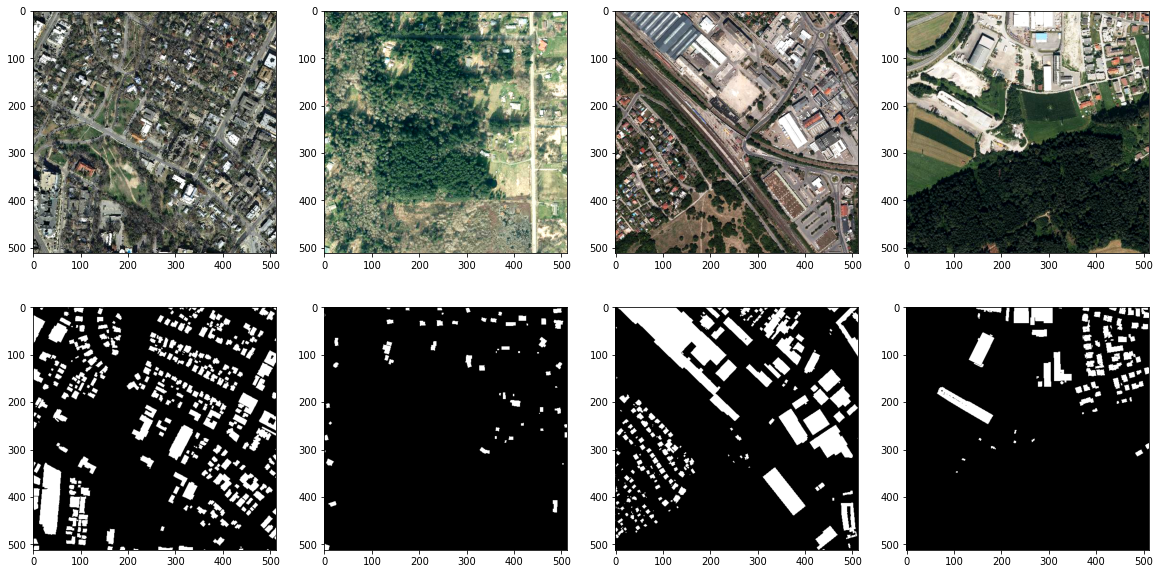

In [ ]:
train_example, train_label = next(train_dataset.as_numpy_iterator())
fig, ax = plt.subplots(2,4,figsize=(20,10))
for i in range(4):
    ax[0,i].imshow(train_example[i])
    ax[1,i].imshow(np.reshape(train_label[i],(512,512)),cmap = plt.cm.gray)
plt.show()

### The UNet FCN
We'll program here a "vanilla" UNet based on the architecture described in [de Jong et al. (2019)](https://export.arxiv.org/pdf/1812.05815v2). It consists of a coder and decoder section with lateral connections between the two, which in the literature is usually displayed in the form of a "U". The coder section is a series of 5 pairs of Conv2D convolutional layers, with successively doubling numbers of filters (64, 128, ...), connected by MaxPooling2D layers which successively halve the image dimensions (512, 256, ...). The decoder section reverses the process with the help of upsampling Conv2DTranspose layers, ultimately reconstructing the input image signal at the network output. The input to each upsampling layer conists of the output from the preceding layer, merged (concatenated) with the output of the corresponding Conv2d layer from the coding section. The idea is to restore higher resolution details lost during the image compression (coding) phase while decoding takes place. The model takes as input a three channel RGB image in _np.uint8_ format and outputs an 1-channel image in _np.float32_ format. The output of the last Conv2D layer is passed through a sigmoid activation function.

Since the convolutional layers are all identical except for the number of filters, and since each is followed by a [batch normalization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization) layer, it improves readability to use some shortcut functions. These can be conveniently programmed with the tensorflow _sequential API_:

In [ ]:
# shortcuts
def conv2d(filters):
    return tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(filters,3,activation="relu",padding="same"),
        tf.keras.layers.BatchNormalization()])
def conv2dtranspose(filters):
    return tf.keras.models.Sequential([
        tf.keras.layers.Conv2DTranspose(filters,3,strides=2,activation="relu",padding="same"),
        tf.keras.layers.BatchNormalization()])
def maxpooling2d():
    return tf.keras.layers.MaxPooling2D(pool_size=2,strides=2,padding="same")

Here is the full UNet model written in tensorflow's _functional API_:

In [ ]:
# UNet
def unet_model(num_channels=3,image_size=512):    
    inputs = tf.keras.layers.Input(shape=(image_size,image_size,num_channels))
    rescaled= tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)
#  coder     
    conv11 = conv2d(64)(rescaled)
    conv12 = conv2d(64)(conv11)
    max_pool1 = maxpooling2d()(conv12)
    conv21 = conv2d(128)(max_pool1)
    conv22 = conv2d(128)(conv21)
    max_pool2 = maxpooling2d()(conv22)
    conv31 = conv2d(256)(max_pool2)
    conv32 = conv2d(256)(conv31)
    max_pool3 = maxpooling2d()(conv32)
    conv41 = conv2d(512)(max_pool3)
    conv42 = conv2d(512)(conv41)
    max_pool4 = maxpooling2d()(conv42)
    conv51 = conv2d(1024)(max_pool4)
    conv52 = conv2d(1024)(conv51)
#  decoder    
    uconv51 = conv2dtranspose(512)(conv52)
    merge_dec5 = tf.keras.layers.concatenate([conv42,uconv51],axis=3)
    conv_dec_41 = conv2d(512)(merge_dec5)
    conv_dec_42 = conv2d(512)(conv_dec_41)
    uconv41 = conv2dtranspose(256)(conv_dec_42)
    merge_dec4 = tf.keras.layers.concatenate([conv32,uconv41],axis=3)
    conv_dec_31 = conv2d(256)(merge_dec4)
    conv_dec_32 = conv2d(256)(conv_dec_31)
    uconv31 = conv2dtranspose(128)(conv_dec_32)
    merge_dec3 = tf.keras.layers.concatenate([conv22,uconv31],axis=3)
    conv_dec_21 = conv2d(128)(merge_dec3)
    conv_dec_22 = conv2d(128)(conv_dec_21)
    uconv21 = conv2dtranspose(64)(conv_dec_22)
    merge_dec2 = tf.keras.layers.concatenate([conv12,uconv21],axis=3)
    conv_dec_11 = conv2d(64)(merge_dec2)
    conv_dec_12 = conv2d(64)(conv_dec_11)
#  output    
    conv_dec_12 = conv2d(8)(conv_dec_12)
    output = tf.keras.layers.Conv2D(1,1,activation = 'sigmoid')(conv_dec_12)
    return tf.keras.Model(inputs = inputs, outputs = output)

In [ ]:
model = None
model = unet_model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 512, 512, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
sequential_23 (Sequential)      (None, 512, 512, 64) 2048        rescaling_1[0][0]                
__________________________________________________________________________________________________
sequential_24 (Sequential)      (None, 512, 512, 64) 37184       sequential_23[0][0]              
____________________________________________________________________________________________

We'll also use a standard Adam optimizer with a learning rate of 0.001 and a BinaryCrossentropy loss function corresponding to the sigmoid activation.

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0003),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

### Training
During training it is a good idea to include a callback which saves the model after each epoch whenever the loss has been reduced. The Colab notebook's GPU runtime may be disconnected by the provider at any time during training, particularly when the number of epochs is large (e.g., $\approx 100$) and the model state will otherwise be lost. Since training data are scarce, we will use the test data for both validation and testing.

In [ ]:
callback = ModelCheckpoint(train_folder+'/unet_inria_model.h5', monitor='loss', save_best_only=True)
history = model.fit(train_dataset, epochs=20, callbacks = [callback], validation_data=test_dataset)

Epoch 1/20
165/165 [==============================] - 185s 1s/step - loss: 0.0701 - binary_accuracy: 0.9718 - val_loss: 0.1990 - val_binary_accuracy: 0.9380
Epoch 2/20
165/165 [==============================] - 185s 1s/step - loss: 0.0685 - binary_accuracy: 0.9724 - val_loss: 0.2173 - val_binary_accuracy: 0.9349
Epoch 3/20
165/165 [==============================] - 185s 1s/step - loss: 0.0697 - binary_accuracy: 0.9720 - val_loss: 0.2134 - val_binary_accuracy: 0.9359
Epoch 4/20
165/165 [==============================] - 185s 1s/step - loss: 0.0702 - binary_accuracy: 0.9718 - val_loss: 0.2095 - val_binary_accuracy: 0.9366
Epoch 5/20
165/165 [==============================] - 185s 1s/step - loss: 0.0647 - binary_accuracy: 0.9738 - val_loss: 0.2096 - val_binary_accuracy: 0.9382
Epoch 6/20
165/165 [==============================] - 185s 1s/step - loss: 0.0612 - binary_accuracy: 0.9752 - val_loss: 0.2082 - val_binary_accuracy: 0.9392
Epoch 7/20
165/165 [==============================] - 185s

In [10]:
model = keras.models.load_model(train_folder+'/unet_inria_model.h5')

### Evaluation

In [ ]:
model.evaluate(test_dataset)

15/15 [==============================] - 6s 357ms/step - loss: 0.1897 - binary_accuracy: 0.9311


[0.18974818289279938, 0.9310874342918396]

### Intersection over Union (IoU) test

The comparison metric used inthe INRIA benchmark competition was _intersection over union_ (IoU), referring to the sets of labeled and classified pixels. A value of one implies perfect reproduction of the label image, a value zero means no correpondance whatsoever. The cell below calculates the average IoU for the test image/label pairs (recall that they are stored in memory in batches of 4).

In [ ]:
i = 0
sumIoU = 0
for test_example, test_label in test_dataset:
    for j in range(4):
        label = np.reshape(test_label[j],(512,512))
        example = np.reshape(test_example[j],(1,512,512,3))
        pred = model.predict(example)
        pred = np.reshape(np.where(pred>0.5,1,0),(512,512))
        I = np.where(np.logical_and(label==1, pred==1),1,0)
        U = np.where(np.logical_or(label==1, pred==1),1,0)
        sumIoU += np.sum(I)/np.sum(U)
        i += 1        
sumIoU/i

0.6376323242550885

This result correponds closely to the best results obtained by [Maggiori et al. (2017)](https://hal.inria.fr/hal-01468452/document) in the initial benchmarking of the INRIA dataset using a multi-label perceptron (MLP) architecture. The [winners](https://hal.inria.fr/hal-01767807/document) of the competition, however, achieved IoUs of the order 0.7 with variations of the UNet model that we are using here. We should remember that all of the competition exercises were performed at 30cm spatial resolution, whereas we are training at 1.2m resolution with a corresonding loss in object discrimination.

### Visual testing

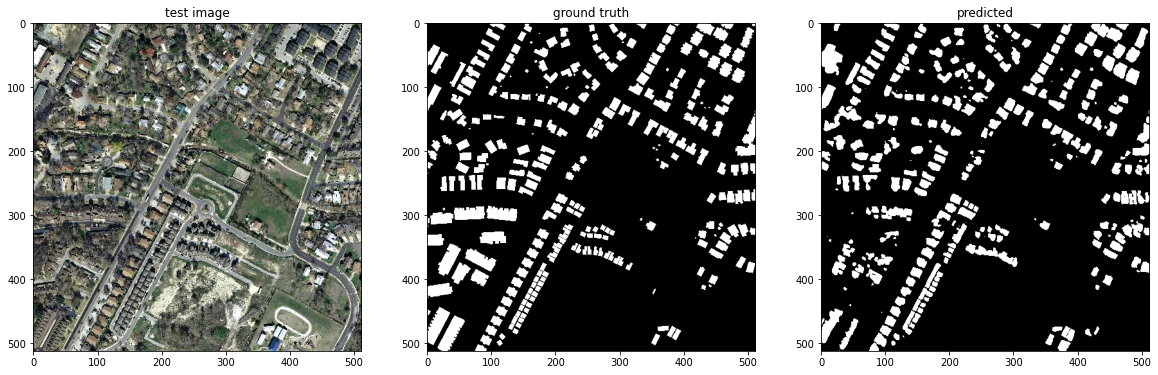

In [ ]:
i = 2
test_example, test_label = next(iter(test_dataset))
fig, ax = plt.subplots(1,3,figsize=(20,10))
ax[0].imshow(test_example[i])
label = np.reshape(test_label[i],(512,512))
ax[1].imshow(label,cmap = plt.cm.gray)
pred = model.predict(tf.reshape(test_example[i],(1,512,512,3)))
pred = np.reshape(np.where(pred>0.5,1,0),(512,512))
ax[2].imshow(pred,cmap = plt.cm.gray)
ax[0].set_title('test image')
ax[1].set_title('ground truth')
ax[2].set_title('predicted')
plt.show()

### New data (NAIP, SkySAT)

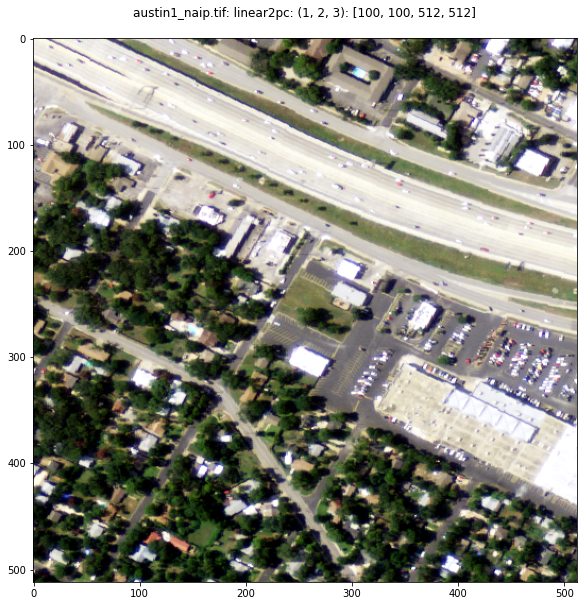

In [ ]:
%run /content/drive/MyDrive/scripts/dispms -f /content/drive/MyDrive/gee/austin1_naip.tif -e 3 -p [1,2,3] -d [100,100,512,512]

In [6]:
%run /content/drive/MyDrive/scripts/unetclassify -h

            
Usage: 
--------------------------------------

Deep learning semantic classification of hi-res images
for building identification

python /content/drive/MyDrive/scripts/unetclassify.py [OPTIONS] filename

Options:
  -h            this help
  -m  <string>  path to stored model        
  -d  <list>    spatial subset [x,y,width,height]
  -t  <float>   probability threshold (default 0.9)
  
Classes:                   
                    0 'All background',
                    1 'Buildings',
  
Assumes rgb image bands only 
  
  -------------------------------------


In [28]:
%run /content/drive/MyDrive/scripts/unetclassify -d [100,100,1024,1024] -t 0.2 -m /content/drive/MyDrive/Inria/unet_inria_model.h5 /content/drive/MyDrive/gee/austin1_naip.tif

Map written to: /content/drive/MyDrive/gee/austin1_naip_cnn.tif
Elapsed time: 1.2084426879882812


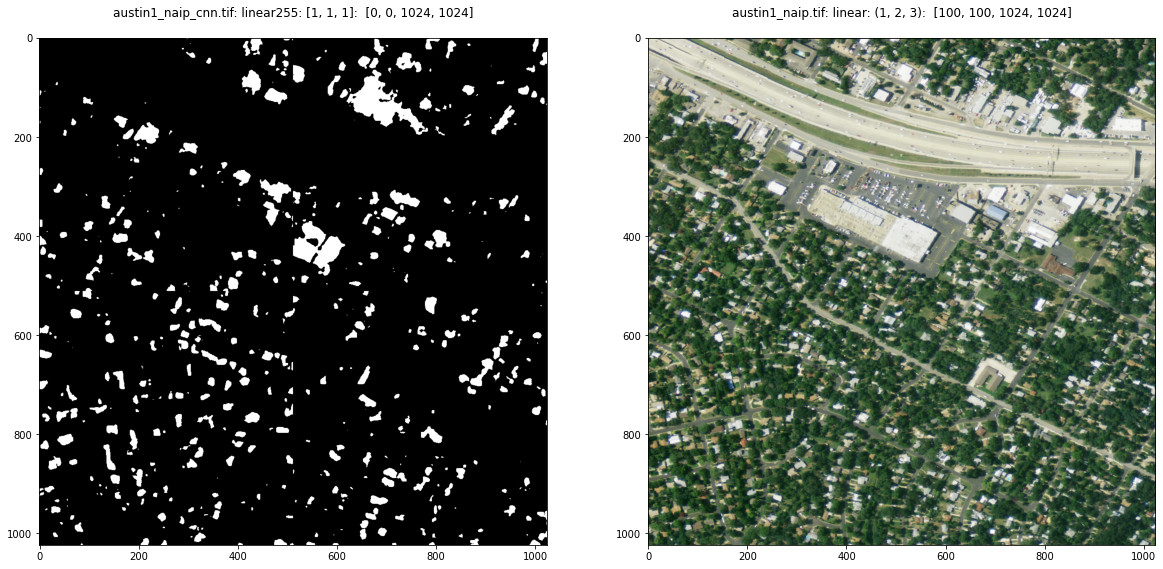

In [30]:
%run /content/drive/MyDrive/scripts/dispms -f /content/drive/MyDrive/gee/austin1_naip_cnn.tif  -e 1 \
-F /content/drive/MyDrive/gee/austin1_naip.tif -E 2 -P [1,2,3] -D [100,100,1024,1024]